<a href="https://colab.research.google.com/github/tnptw/Tuberculosis-Detection/blob/main/Tuberculosis_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup & Import**

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.0 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 1.2 MB 33.1 MB/s 
     |████████████████████████████████| 189 kB 41.7 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 51 kB 288 kB/s 
Mounted at /content/gdrive


In [2]:
import numpy as np 
import pandas as pd 
import cv2
import imageio
import io
import shutil
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff
from PIL import Image
import requests
from io import BytesIO
from fastai.vision.all import *
%matplotlib inline
import os
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
#!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **Create the training set**

In [3]:
path = "/content/gdrive/MyDrive/Tuberculosis_Chest_X-rays/images" #image folder path

def is_tuberculosis(x): return x[12] == '1'
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_tuberculosis, item_tfms=Resize(224))

#dls = ImageDataLoaders.from_folder(path,valid_pct=0.2, seed=42, item_tfms=Resize(224))
print(len(dls.train_ds.items[:])) # Amount of training set

530


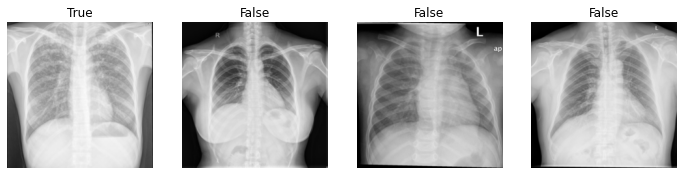

In [4]:
dls.train.show_batch(max_n=4, nrows=1)

In [5]:
def label_func(x):
    return "True" if x.name[12] == '1' else "False"

dtb = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func,
    item_tfms=Resize(224))

dls = dtb.dataloaders(path)

## **Data Augmentation** ##

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning:

torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)



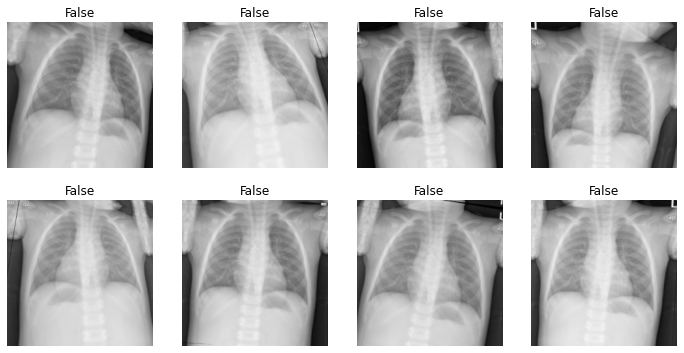

In [6]:
dtb = dtb.new(item_tfms=Resize(224), batch_tfms=aug_transforms(mult=1))
dls = dtb.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## **Training the model**

In [24]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, Precision(), Recall(), F1Score()]).to_fp16()
#learn.fit_one_cycle(3,0.00083)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

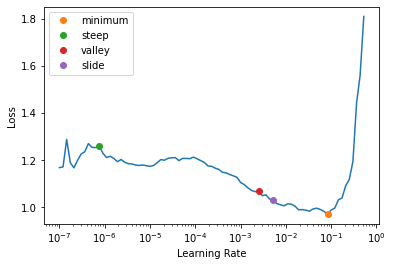

In [25]:
# learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [26]:
lrs.steep

7.585775847473997e-07

In [27]:
lrs.valley

0.002511886414140463

In [ ]:
learn.lr_find(stop_div=False)

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(6,6.309573450380412e-07)

In [ ]:
learn.fit_one_cycle(12,lr_max = slice(6.309573450380412e-07,0.00013182566908653826))

In [28]:
learn.fine_tune(epochs=21,
          base_lr=0.002511886414140463,
          freeze_epochs=1, #how many epochs to train frozen
          lr_mult=100, #train feature extractor with max lr at base_lr/lr_mult
          pct_start=0.3, #start decreasing lr at 
          div=5.0, #start at base_lr (max lr) / div
          cbs=[SaveModelCallback(monitor='f1_score')] # Save Best model
          )

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.048029,3.150347,0.484848,0.000000,0.000000,0.000000,01:38


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Better model found at epoch 0 with f1_score value: 0.0.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.706439,2.596919,0.484848,0.000000,0.000000,0.000000,01:38
1,0.737627,2.384688,0.492424,1.000000,0.014706,0.028986,01:38
2,0.665410,2.220818,0.530303,1.000000,0.088235,0.162162,01:40
3,0.622021,1.469734,0.598485,0.941176,0.235294,0.376471,01:39
4,0.574793,0.918823,0.704545,0.871795,0.500000,0.635514,01:39
5,0.538217,0.619522,0.772727,0.895833,0.632353,0.741379,01:39
6,0.504835,0.587165,0.810606,0.802817,0.838235,0.820144,01:39
7,0.492204,0.491908,0.856061,0.855072,0.867647,0.861314,01:38
8,0.461697,0.541788,0.840909,0.898305,0.779412,0.834646,01:38
9,0.426960,0.509763,0.825758,0.846154,0.808824,0.827068,01:38


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 1 with f1_score value: 0.028985507246376812.
Better model found at epoch 2 with f1_score value: 0.1621621621621622.
Better model found at epoch 3 with f1_score value: 0.3764705882352941.
Better model found at epoch 4 with f1_score value: 0.6355140186915887.
Better model found at epoch 5 with f1_score value: 0.7413793103448276.
Better model found at epoch 6 with f1_score value: 0.8201438848920864.
Better model found at epoch 7 with f1_score value: 0.8613138686131386.


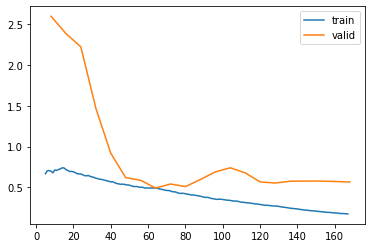

In [29]:
learn.recorder.plot_loss()

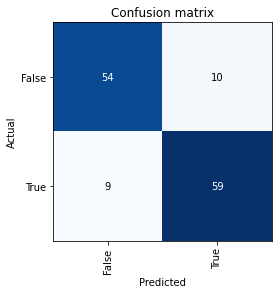

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## **Perform on the Test Set** #

In [48]:
def label_func(x):
    return "True" if x.name[12] == '1' else "False"

dtb = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func,
    item_tfms=Resize(224))

testpath = "/content/gdrive/MyDrive/Tuberculosis_Chest_X-rays/images_test" #image folder path
dls = dtb.dataloaders(testpath)

learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, Precision(), Recall(), F1Score()]).to_fp16()
#load trained model
learn.load('model');

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning:

Saved filed doesn't contain an optimizer state.



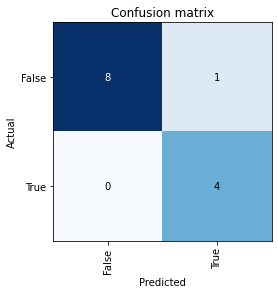

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [50]:
interp.print_classification_report()

              precision    recall  f1-score   support

       False       1.00      0.89      0.94         9
        True       0.80      1.00      0.89         4

    accuracy                           0.92        13
   macro avg       0.90      0.94      0.92        13
weighted avg       0.94      0.92      0.93        13

